Generate temperature, salinity, and nutrient initial files to use in MITgcm runs.

Functions to generate T, S, and nutrient initial conditions (profiles) for MITgcm
=========================================================================

Choose between linear profile and profile interpolated from Pathways Curise 2013 at Barkley Canyon data.
K. Ramos-Musalem

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import seaborn as sns

%matplotlib inline

In [3]:
sns.set_context('notebook')
sns.set_style('ticks')

In [4]:
def iniTracer(xsize, ysize, IniDepth, IniProfile, InterpDepth):
    
    InterpProfile = np.interp(InterpDepth, IniDepth , IniProfile)
    
    tracer = np.zeros((xsize, ysize, len(InterpDepth)))
    
            
    for kk in np.arange(len(InterpDepth)):
        tracer[ii,jj,kk]=np.ones(ysize,xsize)*InterpProfile[kk] 
            

    return tracer

In [5]:
def iniTracerLin(xsize, ysize, TopVal,BotVal, Depth ):
    '''Generate linear nutrient profile (i.e. C(Depth)= IniVal*Depth)''' 
    
    M = (BotVal-TopVal)/(Depth[len(Depth)-1]-Depth[0])
    b = (TopVal - M*Depth[0])*np.ones((len(Depth),1))
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    
    for kk in np.arange(len(Depth)):
        tracer[:,:,kk]=np.ones((xsize,ysize))*(M*Depth[kk]+b[kk]) 
            

    return tracer

In [6]:
def iniTracerStep(xsize, ysize, TopVal, BotVal, Hs, Depth):
    ''' Generate a step nutrient profile with TopVal the value on top of the step and BotVal below
     (i.e. C(z)= TopVal for z > Zs) 
               = BotVal for z < Zs. 
     Here z=0 is at the surface and increases downwards.
     Hs is the depth of the step (positive)'''
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    print(np.shape(tracer))
    for kk in np.arange(len(Depth)):
        if Depth[kk] < Hs:
            tracer[:,:,kk]= np.ones((xsize,ysize))*TopVal
            #print(Depth[kk],tracer[1,1,kk])
        else:
            tracer[:,:,kk]= np.ones((xsize,ysize))*BotVal
            #print(Depth[kk],tracer[1,1,kk])

            

    return tracer

In [7]:
def iniTracerLinHor(xsize, zsize, TopVal,BotVal, yvec ):
    '''Generate linear nutrient profile (i.e. C(yvec)= IniVal*yvec)''' 
    
    M = (BotVal-TopVal)/(yvec[len(yvec)-1]-yvec[0])
    b = (TopVal - M*yvec[0])*np.ones((len(yvec),1))
    
    tracer = np.zeros((xsize,len(yvec),zsize))
    
    for ii in np.arange(xsize):
        for jj in np.arange(zsize):
            for kk in np.arange(len(yvec)):
                tracer[ii,kk,jj]=M*yvec[kk]+b[kk] 
            

    return tracer

In [8]:
def iniTracerCnt(xsize, ysize, CntVal, Depth ):
    '''Generate constant nutrient profile'''  
    
    tracer = np.ones((xsize, ysize, len(Depth)))
    tracer = tracer*CntVal
    

    return tracer

In [9]:
def iniTracerArctan(xsize, ysize, a, Hs, Csb, Depth ):
    '''
    This function generates an array of size (xsize x ysize x len(Depth)) of tracer concentration
    that changes vertically as C(z) = -1.5*arctan(a*(z+Hs)) + Csb and is horizontally uniform.
    
    INPUT
    xsize: int: number of grid points along x
    ysize: int: number of grid points along y
    a:   float: parameter that multiplies argument of arctan
    Hs:  float: Shelf break depth
    Csb: Initial concentration at shelf break (from linear profile this is 32.6 microM)
    Depth: 1d array: Depth levels to intepolate into.
    
    OUTPUT
    tracer: 3d array: Concentration at every grid point
    
    '''
    C1d = -1.5 * np.arctan(a * (-Depth + Hs)) + Csb # 1D array
    
    tracer = np.expand_dims(np.expand_dims(C1d,0),0) # expand dimensions to be 3D
    
    # remember things have to be x,y,z and eventually MITgcm gives out z,y,x
    grid_zeros = np.zeros((xsize, ysize, len(Depth))) 
    
    tracer = tracer + grid_zeros       

    return tracer

In [10]:
def iniTracerParabolic(xsize, ysize, Co, C1, C2, Hs, Depth ):
    '''
    This function generates an array of size (xsize x ysize x len(Depth)) of tracer concentration
    that changes vertically as C(z) = Co + C1(z-Hs) + C2(z-Hs)**2 and is horizontally uniform. 
    Sets concentrations smaller than zero to zero.
    
    INPUT
    xsize: int: number of grid points along x
    ysize: int: number of grid points along y
    Co:   float: Backgound concentration
    C1:   float: Gradient parameter
    C2:   float: Curvature parameter
    Hs:  float: Shelf break depth
    Depth: 1d array: Depth levels to intepolate into.
    
    OUTPUT
    tracer: 3d array: Concentration at every grid point
    
    '''
    C1d = Co + (C1 * (Depth-Hs)) + (C2 * (Depth-Hs)**2) # 1D array
    C1d[C1d<0] = 0
    
    tracer = np.expand_dims(np.expand_dims(C1d,0),0) # expand dimensions to be 3D
    
    # remember things have to be x,y,z and eventually MITgcm gives out z,y,x
    grid_zeros = np.zeros((xsize, ysize, len(Depth))) 
    
    tracer = tracer + grid_zeros       

    return tracer

In [11]:
# Profile values from interp nutrient data from Falkor (see NutrientProfilesFalkor.ipynb)

dt = np.dtype('>f8')  # float 64 big endian

nx = 616
ny = 360
nz = 90

#values form interp nutrient data from Falkor (see NutrientProfilesFalkor.ipynb)
depth = [5.,20.,30.,50.,70.,100.,150.,170.,200.,300.,400.,500.,600.,700.,800.,1000.,1200.] 

# 90 layers
#zi = (5, 10,15,20,25,30,35,40,45,50,
#      55,60,65,70,75,80,85,90,95,100,
#      105,110,115,120,125,130,135,140,145,150,
#      155,160,165,170,180,190,200,210,220,230,
#      240,250,260,280,300,320,340,360,380,400,
#      420,440,460,480,500,520,540,560,580,600,
#      620,640,660,680,700,720,740,760,780,800,
#      820,840,860,880,900,920,940,960,980,1000,
#      1020,1040,1060,1080,1100,1120,1140,1160,1180,1200) # Original depth levels (5m resolution top 170m)

zi = (5,10,15,20,25,30,35,40,45,50,
      55,60,65,70,75,80,85,90,95,100,
      105,110,115,120,125,130,135,140,145,150,
      155,160,165,170,175,180,185,190,195,200,
      205,210,215,220,225,230,235,240,245,250,
      255,260,270,280,300,320,340,360,380,400,
      420,440,460,480,500,520,540,560,580,600,
      620,640,660,680,700,720,740,760,780,800,
      840,880,920,960,1000,1040,1080,1120,1160,1200) # 5m resolution top 260m



(90, 616, 360)


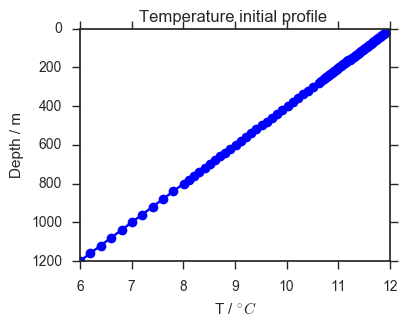

In [16]:
#Temperature

temp = [13.92419179,  10.19468641,   8.58686415,   7.45058646,
         7.28092498,   7.19139622,   6.92763903,   6.85987391,
         6.68035617,   6.11261289,   5.65138553,   5.30145515,
         4.94772486,   4.53669634,   4.17122877,   3.66913223,   3.21469724]  #Falkor Temp

#Temp=iniTracer(nx,ny,depth,temp,zi)
Temp = iniTracerLin(nx,ny,20.0,3.0,zi)

# Save binary file
tmpfile = "%dx%dx%d/Lintmp_N006===_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Temp2 = Temp.transpose((2,0,1)) # To keep fortran order when writing as C binary
print(np.shape(Temp2))
Temp2.astype(dt).tofile(fileobj,"")
fileobj.close()


# PLOT
fig, ax = plt.subplots(1,1,figsize=(4,3))

CS = ax.plot(np.squeeze(Temp[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
plt.xlabel('T / $^{\circ}C$')
    
plt.ylabel('Depth / m')
    
plt.title('Temperature initial profile ')



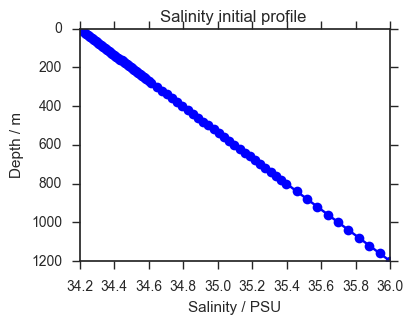

In [17]:
#Salinity

sal = [32.05565615,  32.47904982,  32.69883153,  33.14754095,
        33.45287546,  33.74755425,  33.89389881,  33.9139597 ,
        33.93728968,  33.98439263,  34.04611345,  34.09233602,
        34.14232788,  34.22413622,  34.28826251,  34.37998532,  34.4410795 ] #Falkor Salinity

#Sal = iniTracer(nx,ny,depth,sal,zi)
Sal = iniTracerLin(nx,ny,32.0,34.0,zi)

# Save binary file
tmpfile = "%dx%dx%d/Linsal_N5p5_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Sal2 = Sal.transpose((2,0,1)) # To keep fortran order when writing as C binarynp.asfortranarray(Sal)
Sal2.astype(dt).tofile(fileobj,"")
fileobj.close()

# PLOT
fig, ax = plt.subplots(1,1,figsize=(4,3))

ax.plot(np.squeeze(Sal[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
plt.xlabel('Salinity / PSU')
    
plt.ylabel('Depth / m')
    
plt.title('Salinity initial profile ')

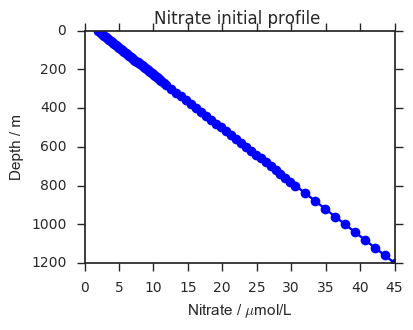

In [33]:
nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate (umol/L)

#Nitrate = iniTracer(nx,ny,depth,nit,zi)
Nitrate = iniTracerLin(nx,ny,2.0,45.0,zi)

               
# Save binary file
tmpfile = "%dx%dx%d/Linnit%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = Nitrate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


# PLOT 
fig, ax = plt.subplots(1,1,figsize=(4,3))

ax.plot(np.squeeze(Nitrate[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
plt.xlabel(r'Nitrate / $\mu$mol/L')
    
plt.ylabel('Depth / m')
    
plt.title('Nitrate initial profile ')


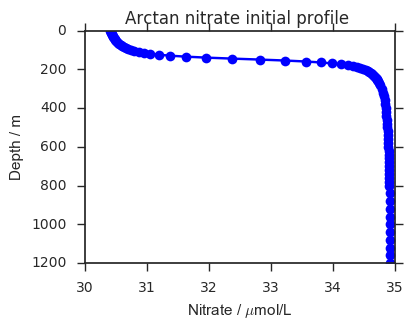

In [34]:
Csb = 32.6 #Falkor Nitrate at 150 m
Hs =147.5
a = 0.06
a_str = '06'

Nit_arctan = iniTracerArctan(nx,ny,a,Hs,Csb,np.array(zi))

               
# Save binary file
tmpfile = "%dx%dx%d/Arctan_nit_%s_%dzlev_%dx%d.bin" %(nx,ny,nz,a_str,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_arctan2 = Nit_arctan.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_arctan2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour
fig, ax = plt.subplots(1,1,figsize=(4,3))

ax.plot(np.squeeze(Nit_arctan[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
ax.set_xlabel(r'Nitrate / $\mu$mol/L')
    
ax.set_ylabel('Depth / m')
    
ax.set_title('Arctan nitrate initial profile ')


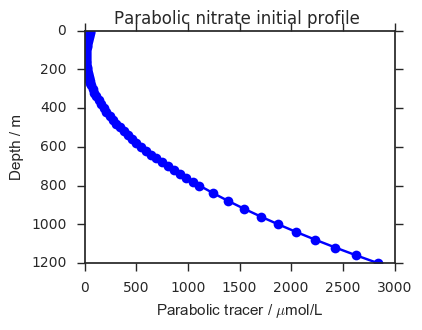

In [35]:
Co = 13.5 #13.5, 150  # To get positive profiles everywhere, arbitrary
Hs =147.5
C1 = 0.05
C2 = 2.5E-3 # 0.00, 0.00036 5.9e-05, -5.3e-05, -0.00029, 2.5E-3,-2.5E-3

a_str= 'Co_13p5_C1_0p05_C2_2p5Em3'

Nit_parab = iniTracerParabolic(nx,ny,Co,C1,C2,Hs,np.array(zi))

               
# Save binary file
tmpfile = "%dx%dx%d/Parab_tr_%s_%dzlev_%dx%d.bin" %(nx,ny,nz,a_str,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_parab2 = Nit_parab.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_parab2.astype(dt).tofile(fileobj,"")
fileobj.close()


### PLOT Contour

fig, ax = plt.subplots(1,1,figsize=(4,3))

ax.plot(np.squeeze(Nit_parab[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
ax.set_xlabel(r'Parabolic tracer / $\mu$mol/L')
    
ax.set_ylabel('Depth / m')
    
ax.set_title('Parabolic nitrate initial profile ')


(616, 360, 90)


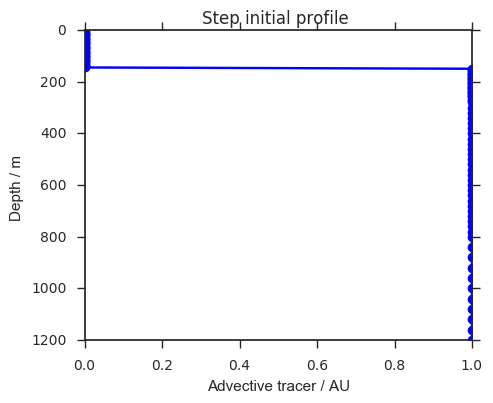

In [39]:
Cs = 1.0 # some arbitrary units
topVal = 0.0 # fill in concetration at 0 above shelf break depth
Hs = 147.5 # Shelf break depth

Nit_step = iniTracerStep(nx,ny,topVal,Cs,Hs,np.array(zi))

# Save binary file
tmpfile = "%dx%dx%d/step_Hs1bottom_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_step2 = Nit_step.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_step2.astype(dt).tofile(fileobj,"")
fileobj.close()


# PLOT

fig,ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(np.squeeze(Nit_step[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
ax.set_xlabel(r'Advective tracer / AU')
    
ax.set_ylabel('Depth / m ')
    
ax.set_title('Step initial profile ')


(616, 360, 90)


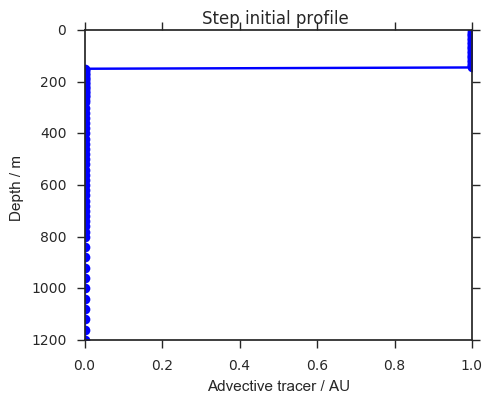

In [40]:
Cs = 0.0 # some arbitrary units
topVal = 1.0 # fill in concetration at 0 above shelf break depth
Hs = 147.5 # Shelf break depth

Nit_step = iniTracerStep(nx,ny,topVal,Cs,Hs,np.array(zi))

# Save binary file
tmpfile = "%dx%dx%d/step_Hs1top_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nit_step2 = Nit_step.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nit_step2.astype(dt).tofile(fileobj,"")
fileobj.close()


# PLOT

fig,ax = plt.subplots(1,1,figsize=(5,4))

ax.plot(np.squeeze(Nit_step[60,45,:]),zi,'bo-')

ax.invert_yaxis()
    
ax.set_xlabel(r'Advective tracer / AU')
    
ax.set_ylabel('Depth / m ')
    
ax.set_title('Step initial profile ')


Let's check what we wrote...

In [41]:
filen = "%dx%dx%d/step_Hs1bottom_%dzlev_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tracer = np.fromfile(filen, dt)

In [42]:
tracer_rsh = np.reshape(tracer,(nx,ny,len(zi)),order='F')
np.shape(tracer_rsh)

(616, 360, 90)

In [44]:
print(np.max(tracer_rsh))

1.0


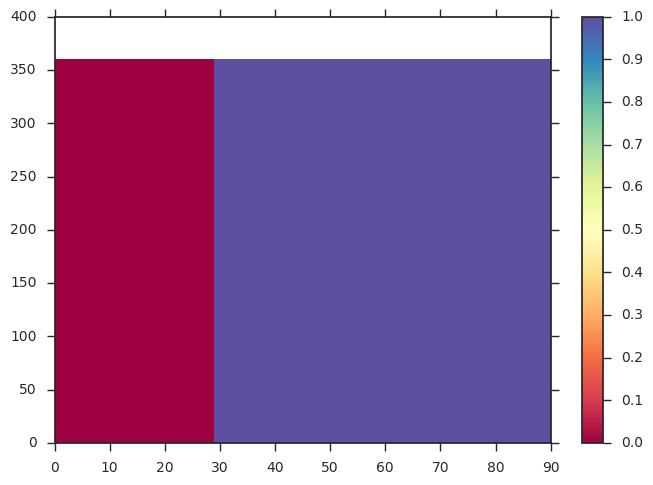

In [48]:
plt.pcolor(tracer_rsh[80,:,:], cmap = 'Spectral')
plt.colorbar()